In [157]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.utils import check_random_state

from collections import OrderedDict
from functools import partial
from time import time
from sklearn import manifold
import collections


## Make Swiss Roll data

We make a 3D swiss-roll with intrinsic dimension 2, where we add gaussian noises to the three axes, and 10 additional dimensions of noises.

In [160]:
def make_swiss_roll(n_samples=100, seed=None):
    if seed is not None:
        rng = check_random_state(seed)

    t = 1.5 * np.pi * (1 + 2 * rng.rand(1, n_samples))
    x = t * np.cos(t)
    y = 21 * rng.rand(1, n_samples)
    z = t * np.sin(t)

    # z_ = np.sort(z)
    # y_[0, np.arange(n_samples//4, 3*n_samples//4)] = 0
    # x_[0, np.arange(800, 1500)] = 0
    # z_[0, np.arange(800, 1500)] = 0

    X = np.concatenate((x, y, z))
    # X = np.concatenate((x_, y_, z_))
    # X += noise * generator.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)

    return X, t

# from megaman.datasets
def _genereate_noises(sigmas, size, dimensions, seed=None):
    if seed is not None:
        rng = check_random_state(seed)
    # if ARD, then different dim gets different sigma
    if isinstance(sigmas, (collections.Sequence, np.ndarray)):
        assert len(sigmas) == dimensions, \
            'The size of sigmas should be the same as noises dimensions'
        return rng.multivariate_normal(np.zeros(dimensions),
                                             np.diag(sigmas), size)
    else:
        return rng.normal(0, sigmas, [size, dimensions])

def _add_noises(data, sigmas=0.1, seed=None):
    size, dim = data.shape
    noises = _genereate_noises(sigmas, size, dim, seed)

    return data + noises

def _add_dims(data, addition_dims, sigmas=0.1, seed=None):
    if addition_dims == 0:
        return data
    else:
        noises = _genereate_noises(sigmas, data.shape[0], addition_dims, seed)

        return np.hstack((data,noises))

def generate_noisy_swiss_roll(size, sigma_primary=0.05, addition_dims=0,
                             sigma_additional=0.1, seed=None):
    swissroll, t = make_swiss_roll(size, seed)
    swissroll = _add_noises(swissroll, sigma_primary, seed)
    swissroll = _add_dims(swissroll, addition_dims, sigma_additional, seed)
    
    return swissroll, t

In [167]:
seed = 1033
n_samples = 1000
sigma_primary = 0.1
additional_dims = 10
sigma_additional = 0.1

X, color = generate_noisy_swiss_roll(n_samples, sigma_primary, additional_dims, sigma_additional, seed)

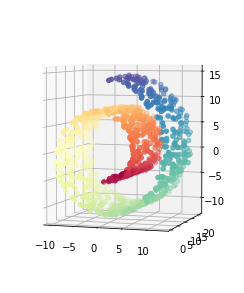

In [168]:
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.show()

## Scikit-Learn `Manifold` Package

In [169]:
# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, neighbors_algorithm='ball_tree', eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
# methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
# methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
#                                            n_neighbors=n_neighbors)
# methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
#                                  random_state=0)

LLE: 0.097 sec
LTSA: 0.25 sec
Hessian LLE: 0.35 sec
Modified LLE: 0.27 sec
Isomap: 0.39 sec


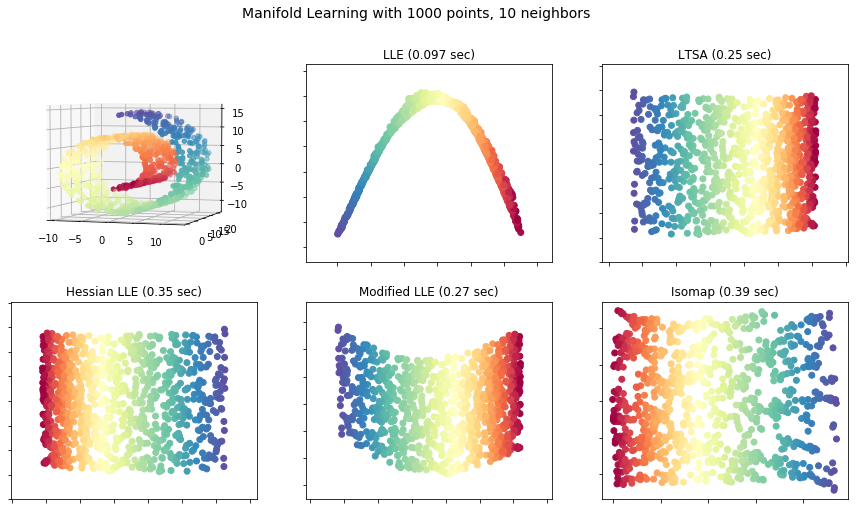

In [170]:
# Plot results
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(231, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 3, 2+i)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
plt.show()

It's confusing how the NN is found using r-NN Ball providing with number of neighbors only.

## Megaman 

First initialise the geometry object, and compute the adjacency matrix, then the affinity matrix and finally graph Laplacian. This object will be used to compute the embedding of the data with different NLDR methods.

In [171]:
from megaman.geometry import Geometry
from scipy.sparse.csgraph import connected_components
from megaman.embedding import (Isomap, LocallyLinearEmbedding,
                               LTSA, SpectralEmbedding)


ModuleNotFoundError: No module named 'megaman'